# The Transformer Encoder: A Modular Implementation from Scratch


## 1. Introduction: The Self-Attention Revolution

The Transformer architecture, introduced by Vaswani et al. in 'Attention Is All You Need', represents a paradigm shift in sequence modeling. Prior to this, Recurrent Neural Networks (RNNs) and LSTMs were the standard, but they suffered from sequential processing bottlenecks and difficulties in capturing long-range dependencies due to vanishing gradients.

The Transformer replaces recurrence entirely with **Self-Attention**, allowing for massive parallelism during training. By attending to all positions in a sequence simultaneously, the model can capture global dependencies regardless of their distance. This study implements the Encoder block from scratch to explore its core modular components: Positional Encoding, Multi-Head Attention, and Feed-Forward Networks.

## 2. Sinusoidal Positional Encoding

Since the Transformer lacks recurrence and convolution, it has no inherent sense of relative or absolute position in a sequence. To address this, we inject 'Positional Encodings' into the input embeddings. We use sine and cosine functions of different frequencies to create a unique spatial footprint for each position.

The encoding is defined as:
$$PE_{(pos, 2i)} = \sin(pos / 10000^{2i/d_{model}})$$
$$PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i/d_{model}})$$


PositionalEncoding class defined.


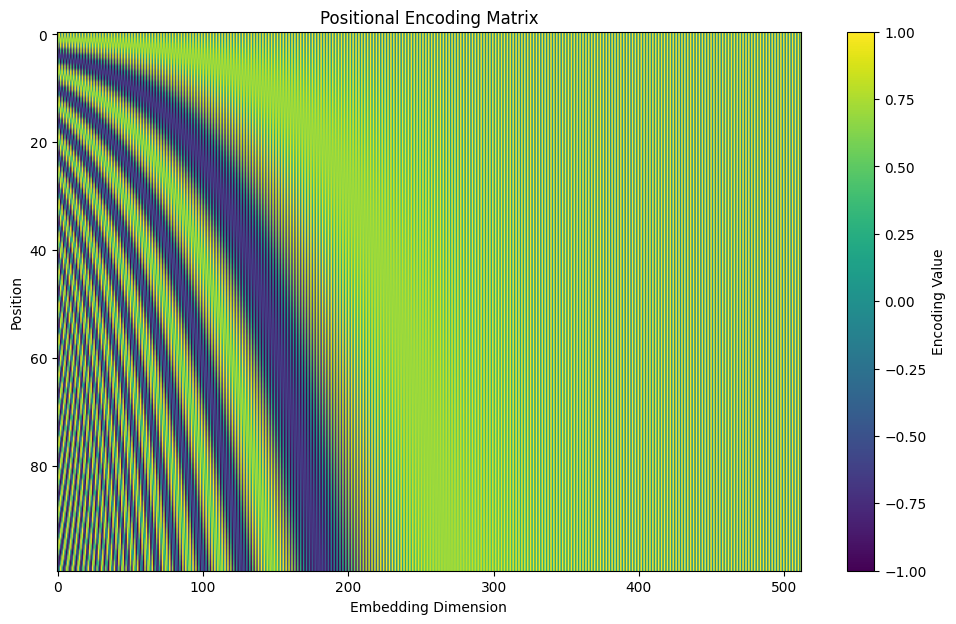

Positional Encoding matrix generated and visualized for d_model=512 and max_len=100.


In [6]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

class PositionalEncoding(nn.Module):
    """
    Implements the sinusoidal positional encoding as described in the
    'Attention Is All You Need' paper. This encoding injects information about
    the relative or absolute position of the tokens in the sequence.

    Args:
        d_model (int): The dimension of the model (embedding size).
        max_len (int): The maximum sequence length for which to generate encodings.

    Returns:
        torch.Tensor: The input tensor `x` with positional encodings added.
                      Shape: (batch_size, seq_len, d_model).
    """
    def __init__(self, d_model: int, max_len: int = 5000):
        super(PositionalEncoding, self).__init__()

        # Create a tensor of shape (max_len, d_model) for positional encodings
        pe = torch.zeros(max_len, d_model)
        # Create a tensor of positions (0 to max_len-1)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        # Calculate the div_term for the sinusoidal functions
        # div_term = 1 / (10000^(2i/d_model))
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))

        # Apply sine to even indices in d_model
        pe[:, 0::2] = torch.sin(position * div_term)
        # Apply cosine to odd indices in d_model
        pe[:, 1::2] = torch.cos(position * div_term)

        # Add an extra dimension for batch size, making it (1, max_len, d_model)
        pe = pe.unsqueeze(0).transpose(0, 1) # Transpose to (max_len, 1, d_model) then unsqueeze for (max_len, 1, d_model)
        # Correcting the shape: (1, max_len, d_model) as intended for batch broadcasting
        pe = pe.transpose(0, 1)

        # Register pe as a buffer, meaning it's part of the module's state but not trainable
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass for PositionalEncoding.

        Args:
            x (torch.Tensor): Input tensor with shape (batch_size, seq_len, d_model).

        Returns:
            torch.Tensor: Output tensor with positional encodings added,
                          shape (batch_size, seq_len, d_model).
        """
        # Add positional encoding to the input. We slice the pre-computed pe
        # to match the sequence length of the input tensor x.
        x = x + self.pe[:, :x.size(1), :]
        return x

print("PositionalEncoding class defined.")

# --- Visualization --- #

# Instantiate PositionalEncoding
d_model = 512
max_len = 100
pos_encoder = PositionalEncoding(d_model, max_len)

# Get the positional encoding matrix for visualization
# We squeeze the first dimension (batch dimension of 1) and convert to numpy
pe_matrix = pos_encoder.pe.squeeze(0).cpu().numpy()

# Plot the Positional Encoding matrix
plt.figure(figsize=(12, 7))
plt.imshow(pe_matrix, cmap='viridis', aspect='auto')
plt.title('Positional Encoding Matrix')
plt.xlabel('Embedding Dimension')
plt.ylabel('Position')
plt.colorbar(label='Encoding Value')
plt.grid(False)
plt.show()

print(f"Positional Encoding matrix generated and visualized for d_model={d_model} and max_len={max_len}.")

## 3. Multi-Head Attention (MHA) Mechanism

Multi-Head Attention allows the model to jointly attend to information from different representation subspaces at different positions. Instead of performing a single attention function, we project the Queries (Q), Keys (K), and Values (V) $h$ times with different linear projections. This enables the model to focus on diverse aspects of the input simultaneously (e.g., syntax vs. semantics).

In [7]:
import torch
import torch.nn as nn

# Assuming MultiHeadAttention and PositionWiseFeedForward are already defined
# (from previous steps)

class TransformerBlock(nn.Module):
    """
    Implements a single Transformer Encoder Block, integrating Multi-Head Attention
    and Position-wise Feed-Forward Networks, along with residual connections
    and layer normalization.

    Args:
        d_model (int): The dimension of the model (embedding size).
        num_heads (int): The number of attention heads in MultiHeadAttention.
        d_ff (int): The dimension of the inner hidden layer in PositionWiseFeedForward.
                    Typically 4 * d_model.
        dropout_rate (float): The dropout rate to apply within the block.

    Returns:
        torch.Tensor: The output tensor after processing through the TransformerBlock,
                      with shape (batch_size, seq_len, d_model).
    """
    def __init__(self, d_model: int, num_heads: int, d_ff: int, dropout_rate: float = 0.1):
        super(TransformerBlock, self).__init__()

        # Multi-Head Attention layer
        self.mha = MultiHeadAttention(d_model, num_heads, dropout_rate)
        # Position-wise Feed-Forward Network
        self.ffn = PositionWiseFeedForward(d_model, d_ff, dropout_rate)

        # Two Layer Normalization layers, one after MHA and one after FFN
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

        # Two Dropout layers, one after MHA output (before norm) and one after FFN output (before norm)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)

    def forward(self, x: torch.Tensor, mask=None) -> torch.Tensor:
        """
        Forward pass for the TransformerBlock.

        Args:
            x (torch.Tensor): Input tensor with shape (batch_size, seq_len, d_model).
            mask (torch.Tensor, optional): Mask for the attention mechanism.

        Returns:
            torch.Tensor: Output tensor with shape (batch_size, seq_len, d_model).
        """
        # Multi-Head Attention Sub-layer
        # Apply MHA, then add residual connection, apply dropout, and finally LayerNorm
        attn_output = self.mha(x, x, x, mask) # Query, Key, Value are all 'x' for encoder block
        # Add & Norm 1
        x = self.norm1(x + self.dropout1(attn_output))

        # Position-wise Feed-Forward Sub-layer
        # Apply FFN, then add residual connection, apply dropout, and finally LayerNorm
        ffn_output = self.ffn(x)
        # Add & Norm 2
        x = self.norm2(x + self.dropout2(ffn_output))

        return x

print("TransformerBlock class defined.")


TransformerBlock class defined.


## 4. Position-Wise Feed-Forward Network (FFN)

Each Transformer layer contains a fully connected feed-forward network, which is applied to each position separately and identically. It consists of two linear transformations with a non-linear activation (typically ReLU or GELU) between them. This component acts as a local transformation that processes the contextualized information generated by the attention mechanism.

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PositionWiseFeedForward(nn.Module):
    """
    Implements the Position-wise Feed-Forward Network (FFN) as described in the
    Transformer architecture. It consists of two linear transformations with a ReLU/GELU
    activation in between.

    Args:
        d_model (int): The dimension of the model (embedding size).
        d_ff (int): The dimension of the inner hidden layer of the feed-forward network.
                    Typically 4 * d_model.
        dropout_rate (float): The dropout rate to apply.

    Returns:
        torch.Tensor: The output tensor after applying the feed-forward network,
                      with shape (batch_size, seq_len, d_model).
    """
    def __init__(self, d_model: int, d_ff: int, dropout_rate: float = 0.1):
        super(PositionWiseFeedForward, self).__init__()
        # First linear layer that expands the input dimension
        self.fc1 = nn.Linear(d_model, d_ff)
        # Second linear layer that projects the expanded dimension back
        self.fc2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout_rate)
        self.activation = nn.GELU() # Using GELU as suggested in modern Transformers

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass for the PositionWiseFeedForward network.

        Args:
            x (torch.Tensor): Input tensor with shape (batch_size, seq_len, d_model).

        Returns:
            torch.Tensor: Output tensor with shape (batch_size, seq_len, d_model).
        """
        # Apply the first linear layer
        x = self.fc1(x)
        # Apply activation function
        x = self.activation(x)
        # Apply dropout
        x = self.dropout(x)
        # Apply the second linear layer
        x = self.fc2(x)
        return x

print("PositionWiseFeedForward class defined.")


PositionWiseFeedForward class defined.


## 5. The Complete Transformer Block

A single Transformer Encoder block integrates Multi-Head Attention and the Feed-Forward Network using a specific workflow. Each sub-layer (MHA, FFN) is followed by a **Residual Connection** (Add) and **Layer Normalization** (Norm), commonly referred to as 'Add & Norm'. Residual connections are vital for training deep networks as they allow gradients to flow more easily through the stack.

## 6. Architectural Validation

To verify the integrity of our implementation, we perform a shape consistency test. One of the structural requirements of the Transformer is that the output of each block must match the input shape $(Batch, Seq\_Len, D\_Model)$, allowing for the modular stacking of multiple layers.

In [8]:
import torch

# 1. Create a dummy test data tensor
batch_size = 2
seq_len = 10
d_model = 512
dummy_input = torch.randn(batch_size, seq_len, d_model)

print(f"Input tensor shape: {dummy_input.shape}")

# 2. Instantiate the TransformerBlock
num_heads = 8
d_ff = 4 * d_model # As per typical Transformer architecture
dropout_rate = 0.1

transformer_block = TransformerBlock(d_model, num_heads, d_ff, dropout_rate)

# 3. Pass the test data tensor through the TransformerBlock
output_tensor = transformer_block(dummy_input)

# 4. Print the shapes of the input and output tensors
print(f"Output tensor shape: {output_tensor.shape}")

# Verify if the shapes match
if dummy_input.shape == output_tensor.shape:
    print("Validation successful: Input and output tensor shapes match.")
else:
    print("Validation failed: Input and output tensor shapes do NOT match.")

Input tensor shape: torch.Size([2, 10, 512])
Output tensor shape: torch.Size([2, 10, 512])
Validation successful: Input and output tensor shapes match.


## 7. Research Conclusion: Scalability and Depth

The modular design of the Transformer Encoder is the foundation of modern Large Language Models (LLMs). By stacking these blocks, models can learn increasingly abstract representations of data. The combination of self-attention's global reach and the stability provided by residual connections and layer normalization has made the Transformer the dominant architecture for NLP, Computer Vision, and beyond.